# Classification with tourism dataset using SARIMAX

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import shap

/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='Fecha', ylabel='Suecia'>

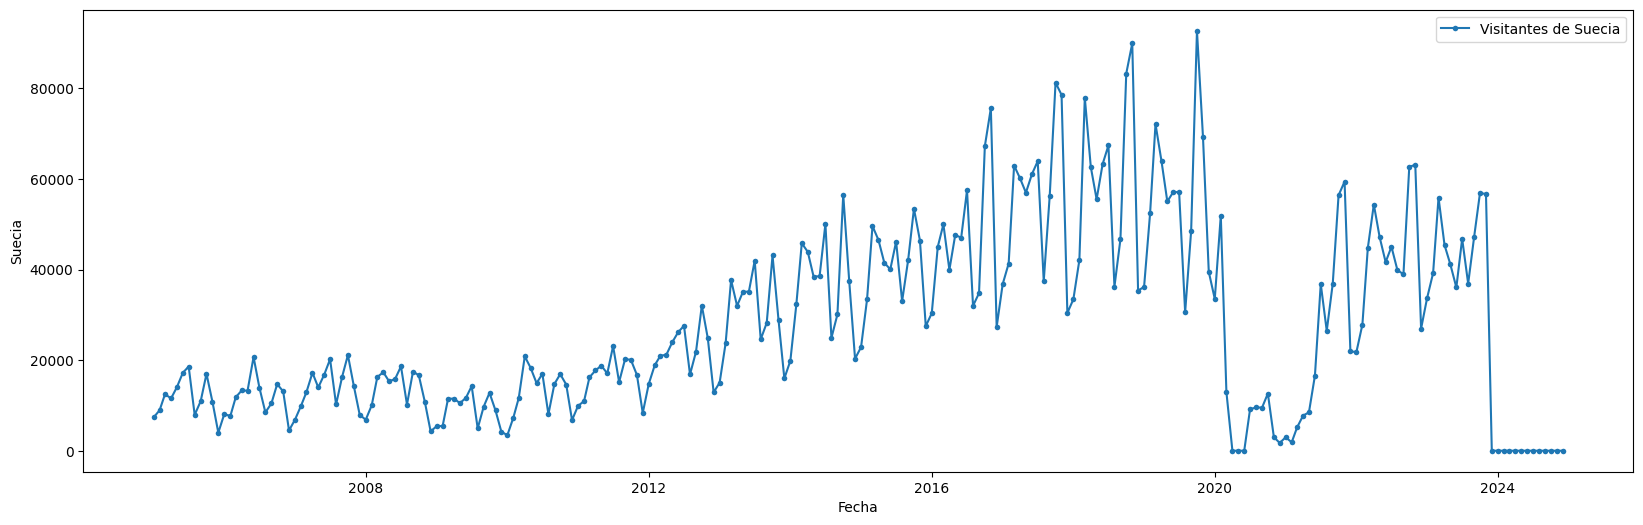

In [20]:
df = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism.csv', sep=";", decimal=".", encoding="utf-8")
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
plt.subplots(1, 1, figsize=(20, 6))
sns.lineplot(x='Fecha', y='Suecia', data=df, label='Visitantes de Suecia', marker='o', markeredgewidth=0, markersize=4)

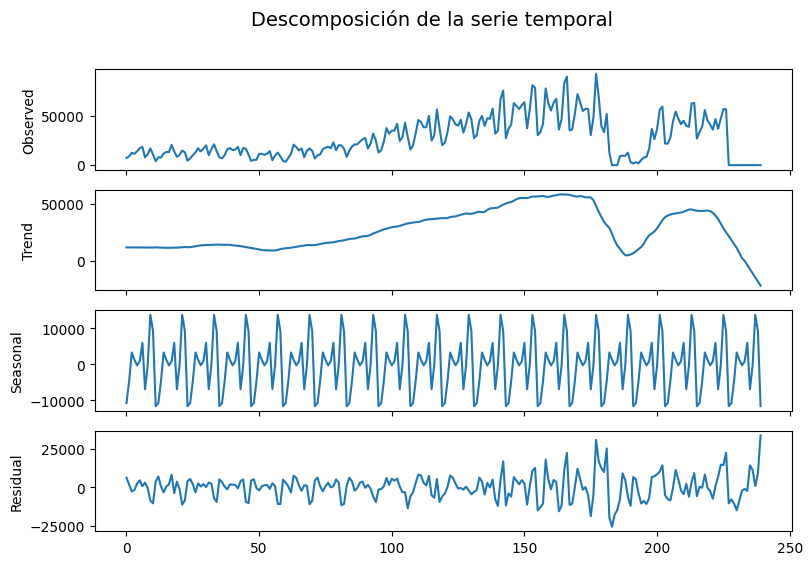

In [37]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)
res_decompose = seasonal_decompose(df['Suecia'], model='additive', period=12, extrapolate_trend='freq')

res_decompose.observed.plot(ax=axs[0], legend=False)
axs[0].set_ylabel('Observed')
res_decompose.trend.plot(ax=axs[1], legend=False)
axs[1].set_ylabel('Trend')
res_decompose.seasonal.plot(ax=axs[2], legend=False)
axs[2].set_ylabel('Seasonal')
res_decompose.resid.plot(ax=axs[3], legend=False)
axs[3].set_ylabel('Residual')
fig.suptitle('Descomposición de la serie temporal', fontsize=14)
plt.show()

# Train - test split

In [43]:
cut_date = '2015-01'
df_timed = df.set_index('Fecha')
df_train = df_timed.loc[df_timed.index < cut_date].copy()
df_rest = df_timed.loc[df_timed.index >= cut_date].copy()

## SARIMAX

In [83]:
model = SARIMAX(
    endog=df_train['Suecia'].to_numpy(),
    exog=df_train.drop(columns='Suecia').to_numpy(),
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

predictions = {}
for year in range(pd.to_datetime(cut_date).year, pd.to_datetime(df_rest.index[-1]).year+1):
    test_exog = df_rest.loc[df_rest.index.year == year].drop(columns='Suecia').to_numpy()
    pred = model.forecast(steps=12, exog=test_exog)
    predictions[year] = pred

predictions = pd.DataFrame(predictions).T
predictions.columns = [f'{i+1}' for i in range(12)]
predictions
# test_exog = df_rest.loc[df_rest.index.year == df_train.tail(1).index.year.values[0]+1].drop(columns='Suecia').to_numpy()
# pred = model.forecast(steps=12, exog=test_exog)
# pred

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41785D+00    |proj g|=  1.95248D-01

At iterate    5    f=  7.39281D+00    |proj g|=  5.22152D-02

At iterate   10    f=  7.38615D+00    |proj g|=  8.03222D-03

At iterate   15    f=  7.38485D+00    |proj g|=  2.43053D-02

At iterate   20    f=  7.38452D+00    |proj g|=  3.17922D-04

At iterate   25    f=  7.38452D+00    |proj g|=  9.20491D-04

At iterate   30    f=  7.38451D+00    |proj g|=  2.85771D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

,1,2,3,4,5,6,7,8,9,10,11,12
2015,27571.560736,39725.325587,52691.241356,50383.838889,47488.259928,45167.603828,56853.893168,34363.409995,41212.197894,66081.921164,45303.696953,29919.375048
2016,34248.652369,46027.570795,60226.095853,55020.148367,51069.964284,52112.220851,64552.732279,40487.148256,46306.905271,71991.710190,52489.352258,34514.005902
2017,37484.723539,50524.894495,66401.252867,68910.346614,65262.350279,66447.558083,78900.577310,50405.777276,57762.592048,82116.046770,58450.378033,42714.776198
2018,44101.332114,56156.941452,74072.976582,69768.711137,65919.778049,66091.478365,78814.519847,53251.489032,62183.326469,85249.986485,65219.720172,51038.938506
2019,47837.674416,62025.839191,78028.566617,78141.322822,73490.760865,74069.939636,85210.522120,54730.311870,65265.646844,89400.390392,67481.971315,52760.192146
2020,50161.913495,63143.632341,64857.936153,47654.481571,46345.280179,45646.645872,59278.868273,40320.298556,46411.423769,71037.189216,51861.968569,37400.193930
2021,39591.519886,50021.877847,62469.139408,57450.506735,56154.064625,59304.374635,74597.574434,53643.077975,63794.820134,89062.155934,69831.461873,54508.430522
2022,54873.374684,68634.212851,85415.864214,87580.877791,85414.635489,85444.212463,91333.196891,76267.243798,89578.151366,112070.324296,93068.951169,82317.893494
2023,81286.113839,93205.612803,111264.046381,111300.840658,106676.053590,108594.466165,119543.381431,93458.515726,103181.602142,125419.047540,105402.145498,90853.767407
2024,96715.585073,105923.345902,118040.980808,112161.623965,108750.109177,105778.298564,107722.289188,92262.162287,97479.139767,120228.342587,108223.265310,91103.103736


In [88]:
plotable_preds = pd.DataFrame(predictions.stack()).reset_index()
plotable_preds["Fecha"] = pd.to_datetime(plotable_preds["level_0"].astype(str) + "-" + plotable_preds["level_1"].astype(str), format='%Y-%m')
plotable_preds = plotable_preds.set_index("Fecha")
plotable_preds = plotable_preds.drop(columns=["level_0", "level_1"])
plotable_preds.columns = ["Predicción"]
plotable_preds

,Predicción
Fecha,
2015-01-01,27571.560736
2015-02-01,39725.325587
2015-03-01,52691.241356
2015-04-01,50383.838889
2015-05-01,47488.259928
...,...
2024-08-01,92262.162287
2024-09-01,97479.139767
2024-10-01,120228.342587


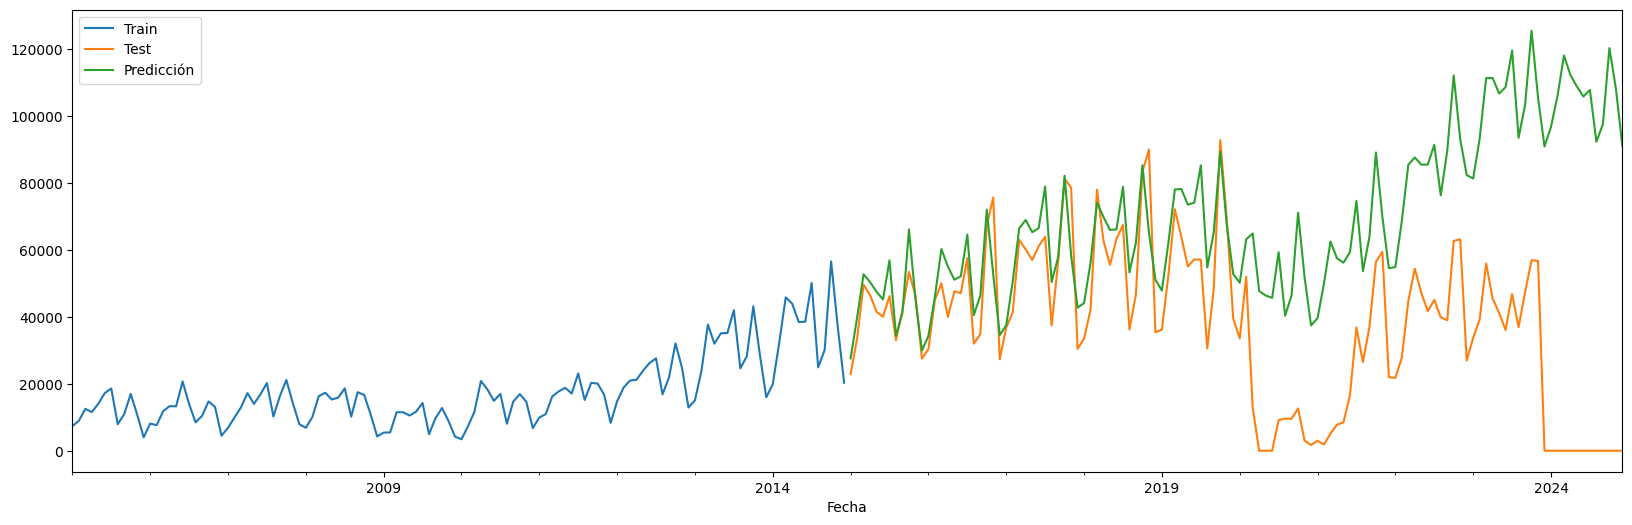

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
df_train['Suecia'].plot(ax=ax, label='Train')
df_rest['Suecia'].plot(ax=ax, label='Test')
plotable_preds['Predicción'].plot(ax=ax, label='Predicción')
plt.legend()



In [67]:
explainer = shap.KernelExplainer(model, data=df_train.drop(columns='Suecia').to_numpy())
shap_values = explainer.shap_values(df_train.drop(columns='Suecia').to_numpy())
shap.summary_plot(shap_values, df_train.drop(columns='Suecia'))

Provided model function fails when applied to the provided data set.


TypeError: 'SARIMAXResultsWrapper' object is not callable